In [2]:
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow import keras

from keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt

## Load Dataset

Read the test and training data into variables. Images are already processed here, i.e. correctly sized, converted to numpy arrays (..).

In [3]:
train_dir = './ds/train/'
test_dir = './ds/test/'

classes = [os.path.basename(x[0]) for x in os.walk("./ds/train") if x[0]][1:]
num_classes = len(classes)
print(classes)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [4]:
# Load data into arrays and apply preprocessing
def load_data(path):
    data = []
    for c, category in enumerate(classes):
        images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path + category) for f in filenames]

        for img_path in images:
            img = image.load_img(img_path, target_size=(224, 224))  
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            data.append({'x' : np.array(x[0]), 'y' : c})

    return data


data_train_val = load_data(train_dir)
data_test = load_data(test_dir)

In [5]:
# Divide data into images and corresponding labels
X_train_val, y_train_val = np.array([t["x"] for t in data_train_val]), [t["y"] for t in data_train_val]
X_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]

## Data Analysis

Analyze the class distribution. It becomes visible that the dataset is imbalanced since some classes are twice as large as others. This will impact the model's performance but for the baseline, we keep this imbalance unchanged.

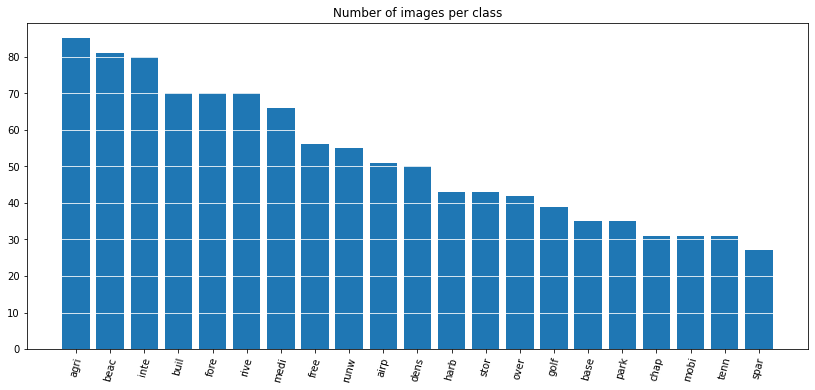

In [6]:
unique, counts = np.unique(y_train_val, return_counts=True)
ticks = np.arange(len(counts))
class_dist = sorted(zip(classes, counts), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(14,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, [c[1] for c in class_dist])
plt.xticks(ticks, [c[0][:4] for c in class_dist], rotation=75)
plt.title('Number of images per class')
plt.show()

## Prepare Data

Data is split into train and validation. The latter is used during model fitting while the test data is solely used to evaluate the final performance.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.2)

# Convert classes to one-hot vectors
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('Train images:', len(y_train), y_train.shape)
print('Test images:', len(y_test), y_test.shape)
print('Val images:', len(y_val), y_val.shape)

Train images: 872 (872, 21)
Test images: 279 (279, 21)
Val images: 219 (219, 21)


## Model Creation and Training

Create a CNN model with fairly standard architecture. Then, fit and train the model.

In [ ]:
def get_model():
    model = Sequential()
    print("Input dimensions:", X_train.shape[1:])

    model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # model.summary()

    return model


In [ ]:
baseline_model = get_model()

baseline_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Create checkpoints during training
filepath = './models/baseline_v1/baseline_v1_{epoch:02d}_{val_accuracy:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model
history = baseline_model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list,
                    workers=3)

#### Visualize training progress along epochs

Plot the (val_)accuracy and (val_)loss along epochs to identify over- and underfitting.

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label='validation')
ax.plot(history.history["loss"], label='train')
ax.legend(loc="upper right")
ax.set_title("Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label='validation')
ax2.plot(history.history["accuracy"], label='train')
ax2.legend(loc="lower right")
ax2.set_title("Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

## Evaluation

#### Analysis of model performance on test data

In [9]:
# NOTE: By default, the finished model is loaded from the repository in order to evaluate
# without compiling and fitting the model again. However, if you train again,
# uncomment the following line and comment the load_model() call below

# test_model = baseline_model
test_model = keras.models.load_model('./models/baseline_v1/baseline_v1_epochs=17_acc=20.h5')

y_pred = test_model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

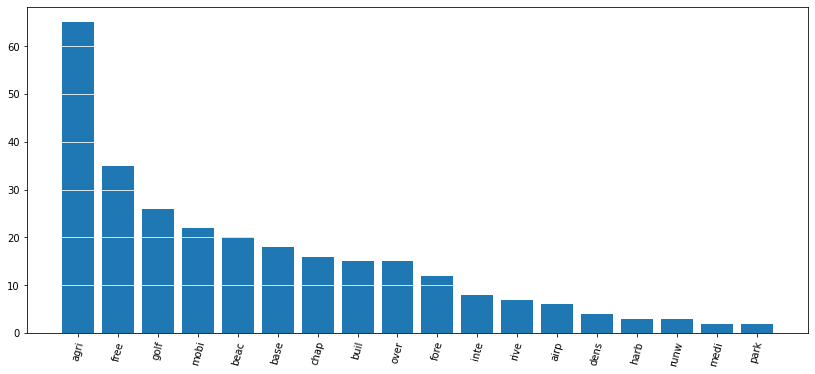

In [10]:
# Plot the distribution of predicted classes

unique, counts = np.unique(y_pred, return_counts=True)
ticks = np.arange(len(counts))
pred_dist = sorted(zip(classes, counts), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(14,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, [c[1] for c in pred_dist])
plt.xticks(ticks, [c[0][:4] for c in pred_dist], rotation=75)
plt.show()

Acc:  0.20430107526881722
Prec:  0.2233363908095091
Rec:  0.20430107526881722


/mnt/f/SmartGit-Repositories/rs-classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


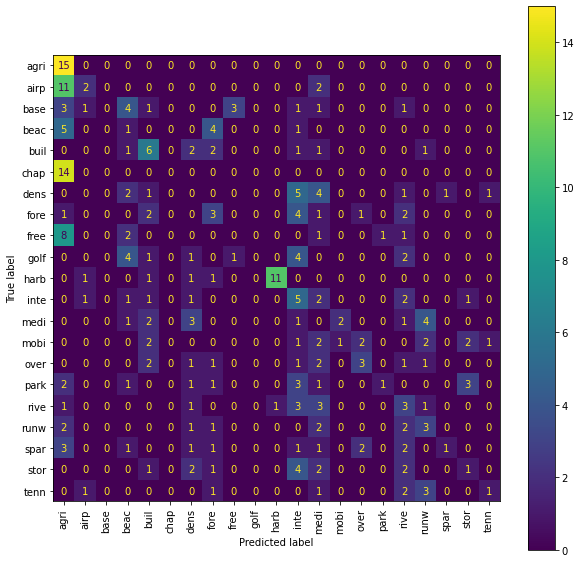

In [11]:
# Plot the confusion matrix and evaluate acc, prec and rec

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=[c[:4] for c in classes])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, xticks_rotation='vertical')

print('Acc: ', accuracy_score(y_true, y_pred))
print('Prec: ', precision_score(y_true, y_pred, average='weighted'))
print('Rec: ', recall_score(y_true, y_pred, average='weighted'))
# Acc:  0.20430107526881722
# Prec:  0.2233363908095091
# Rec:  0.20430107526881722